In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange,tqdm
import argparse
import xlrd

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
def getloclist(wd,end,filter_out):
    loc_list = []
    EIRA_found = False
    for root, dirs, files in os.walk(wd):
        for file in files:
            if file.endswith(end) and not file.endswith(filter_out):
                loc = os.path.join(root, file)
                loc_list.append(loc) #get bim file location
#     if EIRA_found == True:
#         print("EIRA detected!")
#     else:
#         print("Warning! No EIRA bim detected! Use first scanned cohort as ref!")
    return loc_list

In [12]:
def openfile(file,n=0,sep=','):
    if file.endswith((".csv",".CSV")):
        clinical = pd.read_csv(file,sep=sep,skiprows=n)
    elif file.endswith((".xlsx",".xls")):
        clinical = pd.read_excel(file,skiprows=n)
    elif file.endswith(".dta"):
        clinical = pd.read_stata(file)
    else:
#         raise ValueError("no clinical file detected!")
        clinical = pd.DataFrame()
    return clinical
def search(columns,patterns=["sjc","crp","sdai","cdai","mtx","Methotrexate"]):
    list_found = []
    for i in trange(len(columns)):
        for j in patterns:
            if j.lower() in columns[i].lower():
                print("Found pattern",j ,"in column num",i,columns[i])
                list_found.append(columns[i])
    return list_found
def search_folder(loc,patterns=["sjc","crp","sdai","cdai","mtx","Methotrexate"]):
    list_found = []
    for root, dirs, files in os.walk(loc):
        for file in files:
            path = os.path.join(root, file)
            opened = openfile(path)
            print("openning file ",file)
            list_found.append(search(opened.columns,patterns))
    return list_found

In [5]:
#prepare fam and covar file for new cohorts
Manchester_Glasgow = openfile("/exports/reum/CKe/Newdata/clinical/pheno_192Samples_05.11.2021.csv")
Manchester_Glasgow

,study_id,fupno,tjc28_value,sjc28_value,crp_value,sex,age_consent,DAS28_baseline,DAS28_6months,antiCCP
0,RAMS01051,baseline,3,1,18.31,female,56,3.697350,1.944626,pos
1,RAMS01051,6-months,1,0,0.57,female,56,3.697350,1.944626,pos
2,RAMS02026,baseline,8,2,32.12,male,61,4.713943,4.145361,neg
3,RAMS02026,6-months,3,4,26.50,male,61,4.713943,4.145361,neg
4,RAMS02046,baseline,10,5,1.32,female,44,4.119933,3.218685,neg
...,...,...,...,...,...,...,...,...,...,...
379,RAMS20003,6-months,1,1,4.38,male,69,2.639811,2.656345,pos
380,RAMS20022,baseline,17,12,18.23,female,68,5.599650,5.424985,neg
381,RAMS20022,6-months,28,2,9.10,female,68,5.599650,5.424985,neg
382,RAMS30004,baseline,12,2,0.71,female,74,3.698328,4.831751,NaN


In [5]:
tomerge = Manchester_Glasgow[Manchester_Glasgow['fupno']=="6-months"].loc[:,["study_id","sex","age_consent","DAS28_6months"]]
tomerge

,study_id,sex,age_consent,DAS28_6months
1,RAMS01051,female,56,1.944626
3,RAMS02026,male,61,4.145361
5,RAMS02046,female,44,3.218685
7,RAMS02056,female,68,2.989357
9,RAMS02078,female,48,3.246621
...,...,...,...,...
375,RAMS14016,female,65,2.224876
377,RAMS15003,female,61,1.778743
379,RAMS20003,male,69,2.656345
381,RAMS20022,female,68,5.424985


In [9]:
fam_manchester = pd.read_csv("/exports/reum/CKe/Pipelinerun_withPC/Manchester/mergedChr/Manchester_merged.fam",sep='\s+',header=None)
fam_manchester

,0,1,2,3,4,5
0,1_RAMS23006,1_RAMS23006,0,0,0,-9
1,2_RAMS30004,2_RAMS30004,0,0,0,-9
2,7_RAMS20003,7_RAMS20003,0,0,0,-9
3,9_RAMS19034,9_RAMS19034,0,0,0,-9
4,13_RAMS10012,13_RAMS10012,0,0,0,-9
...,...,...,...,...,...,...
183,548_RAMS12114,548_RAMS12114,0,0,0,-9
184,553_RAMS07005,553_RAMS07005,0,0,0,-9
185,558_RAMS07027,558_RAMS07027,0,0,0,-9
186,564_RAMS03012,564_RAMS03012,0,0,0,-9


In [6]:
fam_temp = fam_manchester
fam_temp[0] = fam_temp[0].str.split("_",expand=True)[1]

In [7]:
merge_fam = pd.merge(fam_temp,tomerge,how='left',left_on=0,right_on="study_id")
merge_fam

,0,1,2,3,4,5,study_id,sex,age_consent,DAS28_6months
0,RAMS23006,1_RAMS23006,0,0,0,-9,RAMS23006,male,72,2.417372
1,RAMS30004,2_RAMS30004,0,0,0,-9,RAMS30004,female,74,4.831751
2,RAMS20003,7_RAMS20003,0,0,0,-9,RAMS20003,male,69,2.656345
3,RAMS19034,9_RAMS19034,0,0,0,-9,RAMS19034,female,56,4.609592
4,RAMS10012,13_RAMS10012,0,0,0,-9,RAMS10012,female,43,3.218903
...,...,...,...,...,...,...,...,...,...,...
183,RAMS12114,548_RAMS12114,0,0,0,-9,RAMS12114,female,65,1.639140
184,RAMS07005,553_RAMS07005,0,0,0,-9,RAMS07005,female,56,1.646094
185,RAMS07027,558_RAMS07027,0,0,0,-9,RAMS07027,female,30,4.586477
186,RAMS03012,564_RAMS03012,0,0,0,-9,RAMS03012,female,70,3.880685


In [14]:
def remissionDAS28(score):
    if score < 2.6:
        state = 2 # case: achieve remission
    elif score >= 2.6:
        state = 1 # control: non-remission
    else:
        state = -9
    return state

In [12]:
fam_manchester[0] = fam_manchester[1]
fam_manchester[4] = merge_fam['sex']
fam_manchester[4] = fam_manchester[4].map({"male":1,"female":2})
fam_manchester[5] = merge_fam['DAS28_6months'].map(remissionDAS28)

In [13]:
fam_manchester

,0,1,2,3,4,5
0,1_RAMS23006,1_RAMS23006,0,0,1,2
1,2_RAMS30004,2_RAMS30004,0,0,2,1
2,7_RAMS20003,7_RAMS20003,0,0,1,1
3,9_RAMS19034,9_RAMS19034,0,0,2,1
4,13_RAMS10012,13_RAMS10012,0,0,2,1
...,...,...,...,...,...,...
183,548_RAMS12114,548_RAMS12114,0,0,2,2
184,553_RAMS07005,553_RAMS07005,0,0,2,2
185,558_RAMS07027,558_RAMS07027,0,0,2,1
186,564_RAMS03012,564_RAMS03012,0,0,2,1


In [14]:
fam_manchester.to_csv("/exports/reum/CKe/Pipelinerun_withPC/Manchester/mergedChr/Manchester_merged.fam",sep='\t',header=False,index=False)

In [50]:
covar_manchester = fam_manchester.iloc[:,[0,1]]
covar_manchester.rename({0:"FID",1:'IID'},inplace=True,axis=1)
covar_manchester['Sex'] = fam_manchester[4]
covar_manchester['AGE'] = merge_fam['age_consent']

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_46601/3788970721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covar_manchester['Sex'] = fam_manchester[4]
/tmp/ipykernel_46601/3788970721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [51]:
covar_manchester

,FID,IID,Sex,AGE
0,1_RAMS23006,1_RAMS23006,1,72
1,2_RAMS30004,2_RAMS30004,2,74
2,7_RAMS20003,7_RAMS20003,1,69
3,9_RAMS19034,9_RAMS19034,2,56
4,13_RAMS10012,13_RAMS10012,2,43
...,...,...,...,...
183,548_RAMS12114,548_RAMS12114,2,65
184,553_RAMS07005,553_RAMS07005,2,56
185,558_RAMS07027,558_RAMS07027,2,30
186,564_RAMS03012,564_RAMS03012,2,70


In [53]:
#next: update PCs in PCAworking notebook 
covar_manchester.to_csv("/exports/reum/CKe/Pipelinerun_withPC/Manchester/mergedChr/Manchester_re.covar",index=False,sep='\t')

In [5]:
EarthA = openfile("/exports/reum/knevel_lab/EARTH/SetA/clinical/GWAS_Remission_23082019_V3_Shared_adj.csv",n=1,sep=';')
EarthB = openfile("/exports/reum/knevel_lab/EARTH/SetB/clinical/EA_Samples.xlsx",sep=';')
# Madrid = openfile("/exports/reum/knevel_lab/Madrid/clinical/Additional clincal data pacients GWAS HUP.xls")
Madrid = openfile("/exports/reum/knevel_lab/Madrid/clinical/Clinical_data_GWAS_patients_HUP.dta")

#RAMS CHECKED MANUALLY # CRP have to calculated from logCRP
Vienna = openfile("/exports/reum/knevel_lab/Vienna/clinical/Rachel_data_ready_to deliver.csv",sep=';')
Tacera = openfile("/exports/reum/CKe/Tacera/RA-MAP_data_clinical.csv")

In [14]:
SERA = search_folder("/exports/reum/knevel_lab/SERA/Data/",['ccp','acpa'])

openning file  webEmploy.CSV


100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 48072.25it/s]


openning file  webSteroidInj.CSV


100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 115087.61it/s]


openning file  .DS_Store


0it [00:00, ?it/s]


openning file  DobGender.CSV


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 46776.62it/s]


openning file  webDiagnosis.CSV


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 45590.26it/s]


openning file  webJointFindings.CSV


100%|███████████████████████████████████████| 13/13 [00:00<00:00, 161798.08it/s]


openning file  webConMed.CSV


100%|███████████████████████████████████████| 16/16 [00:00<00:00, 192289.01it/s]


openning file  webReferral.CSV


100%|███████████████████████████████████████| 16/16 [00:00<00:00, 198546.93it/s]


openning file  webCalcs.CSV


100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 90200.09it/s]


openning file  webSwollenJnts.CSV


100%|███████████████████████████████████████| 42/42 [00:00<00:00, 353736.48it/s]


openning file  SERA Final Leiden Manifest.xlsx


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 64527.75it/s]


openning file  webTenderJnts.CSV


100%|███████████████████████████████████████| 42/42 [00:00<00:00, 323230.77it/s]


openning file  webDemog.CSV


100%|███████████████████████████████████████| 11/11 [00:00<00:00, 132578.57it/s]


openning file  Leiden Manifest 14 December 20.xlsx


100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 74235.47it/s]


openning file  webDisease.CSV


100%|████████████████████████████████████████| 34/34 [00:00<00:00, 56433.06it/s]

Found pattern ccp in column num 12 CCPMeasureType
Found pattern ccp in column num 13 CCPFigure
Found pattern ccp in column num 14 CCPTitrePosNeg
Found pattern ccp in column num 15 CCPTitreUpper
Found pattern ccp in column num 16 CCPTiteLower
Found pattern ccp in column num 21 IsCCPDoneYN
Found pattern ccp in column num 23 CCPFigureOperator
Found pattern ccp in column num 31 CCPNAYN


In [53]:
#to search sjc,crp,sdai,cdai,mtx
list_found = search(Madrid_additional.columns,["sjc","crp","sdai","cdai","mtx"])

100%|███████████████████████████████████████| 52/52 [00:00<00:00, 100740.79it/s]

Found pattern sdai in column num 12 sdai_v1
Found pattern cdai in column num 13 cdai_v1
Found pattern sdai in column num 24 sdai_v2
Found pattern cdai in column num 25 cdai_v2
Found pattern sdai in column num 36 sdai_v3
Found pattern cdai in column num 37 cdai_v3


In [6]:
# prepare for gwas with MTX as outcomes, get MTX sample subgroup
cohorts = ['EA127genotypes_merged','EARTH_setB_merged','madrid_merged','RAMS_merged','vienna_merged','sera_merged','EAC_merged']
loc_list = getloclist("./Pipelinerun_withPC/",".fam",("_A1corr.fam","_noDup.fam"))
loc_list_MTX = []
for i in cohorts:
    for j in loc_list:
        if "/"+i in j: #PEAC has EAC inside
            loc_list_MTX.append(j)
            print("found cohort: ",i) 
# MTX in earth a
# EarthA['OldEAC_MTX_Duration'].unique()

found cohort:  EA127genotypes_merged
found cohort:  EARTH_setB_merged
found cohort:  madrid_merged
found cohort:  RAMS_merged
found cohort:  vienna_merged
found cohort:  sera_merged
found cohort:  EAC_merged


In [7]:
loc_list_MTX

['./Pipelinerun_withPC/EARTH_A/mergedChr/EA127genotypes_merged.fam',
 './Pipelinerun_withPC/EARTH_B/mergedChr/EARTH_setB_merged.fam',
 './Pipelinerun_withPC/Madrid/mergedChr/madrid_merged.fam',
 './Pipelinerun_withPC/RAMS/mergedChr/RAMS_merged.fam',
 './Pipelinerun_withPC/Vienna/mergedChr/vienna_merged.fam',
 './Pipelinerun_withPC/SERA/mergedChr/sera_merged.fam',
 './Pipelinerun_withPC/EAC/mergedChr/EAC_merged.fam']

In [19]:
#work on EarthA
EarthA

,DMARD after inclusion,double,RA,2,Source,EA Number,OldEAC_1stDMARD_Date,EAC seen date,Earliest Date,Months since 1st Visit,Between 4 and 18 months,Sex,Age at EAC,HAQ,RF Status,RF Titre,CCP Status,CCP,BL_DMARDS,BL_Steroid,EMS,Symptom duration at EAC (weeks),GlobalVAS,Tender28,Swollen28,ESR,CRP,DAS28,DAS28_CRP,1st cons diag,Working diagnosis latest visit / on discharge,Cigarrettes,Smoking,Smoking Status,Cigarette Pack-Yrs,Alcohol,OldEAC_1stDMARD,OldEAC_1stDMARD_Date.1,OldEAC_2ndDMARD,OldEAC_2ndDMARD_Date,OldEAC_MTX_Duration,OldEAC_MTX_Stopped,Start Abatacept,End Abatacept,Start Abatacept S/C,End Abatacept S/C,Start Abatacept SC,End Abatacept SC,Start Adalimumab,End Adalimumab,Start Adalimumab SC,End Adalimumab SC,Start Baricitinib,End Baricitinib,Start Certolizumab,End Certolizumab,Etanercept,Etanercept SC,Start Folic acid,End Folic acid,Golimumab,Hydroxychloroquine,Infliximab,Start Leflunomide,End Leflunomide,Start Methotrexate PO,End Methotrexate PO,Start Methotrexate SC,End Methotrexate SC,Start Rituximab,End Rituximab,Start Secukinumab,End Secukinumab,Start Steroid IA,End Steroid IA,Start Steroid IM,End Steroid IM,Start Steroid PO,End Steroid PO,Start Sulphasalazine,End Sulphasalazine,Start Tocilizumab,End Tocilizumab,Start Tocilizumab IV,End Tocilizumab IV,Start Tocilizumab S/C,End Tocilizumab S/C,Start Tocilizumab SC,End Tocilizumab SC,Tofacitinib
0,1.0,0,1,3,OldEarth,131,19/04/2007,19-Oct-06,19-okt-06,"0,00","0,00",F,47,"1,25",Negative,0.0,Negative,0.0,NaN,NaN,240,10.0,30.0,15.0,3.0,18.0,10.0,NaN,"4,90",UA,RA,NaN,,Never,NaN,NaN,SZP,19/04/2007,MTX,23/08/2008,ongoing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25-mrt-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0,1,6,OldEarth,142,21/12/2006,6-Nov-06,06-nov-06,"0,00","0,00",M,59,"1,875",Positive,40.0,Negative,0.0,NaN,NaN,480,16.0,75.0,15.0,3.0,24.0,15.0,"5,93","5,66",RA,RA,>0,,Past,NaN,NaN,MTX,21/12/2006,Other,21/12/2006,ongoing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0,1,7,OldEarth,184,15/03/2007,26-Feb-07,26-feb-07,"0,00","0,00",F,79,"1,625",Positive,640.0,Positive,14.0,NaN,NaN,0,8.0,0.0,5.0,4.0,30.0,9.0,"4,19","0,00",RA,RA,NaN,,Never,NaN,NaN,MTX,15/03/2007,NaN,NaN,ongoing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0,1,8,OldEarth,196,24/04/2007,16-Apr-07,16-apr-07,"0,00","0,00",M,43,"1,625",Negative,0.0,Negative,0.0,NaN,NaN,60,25.0,39.0,8.0,0.0,6.0,0.0,"3,48","0,00",RA,RA,>0,,Past,NaN,NaN,MTX,24/04/2007,NaN,NaN,ongoing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15-jun-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19-dec-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25-nov-16,25-nov-16,NaN,NaN,19-dec-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0,1,11,OldEarth,203,20/08/2008,30-Apr-07,30-apr-07,"0,00","0,00",M,61,NaN,Positive,640.0,Positive,116.0,NaN,NaN,120,24.0,760.0,18.0,0.0,35.0,22.0,"5,56","0,00",RA,RA,>0,,Past,NaN,NaN,MTX,20/08/2008,Other,20/08/2008,ongoing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12-jun-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,NaN,0,1,289,New Earth EAC,1032,NaN,23-Oct-18,05-mrt-13,"67,00","0,00",F,68,NaN,Positive,130.0,Positive,340.0,0.0,0.0,NaN,NaN,

In [23]:
EarthA_fam = pd.read_csv("/exports/reum/CKe/Pipelinerun_withPC/EARTH_A/mergedChr/EA127genotypes_merged.fam",sep='\s',header=None)
EarthA_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,EA0131_EA0131,EA0131_EA0131,0,0,0,-9
1,EA0142_EA0142,EA0142_EA0142,0,0,0,-9
2,EA0184_EA0184,EA0184_EA0184,0,0,0,-9
3,EA0196_EA0196,EA0196_EA0196,0,0,0,-9
4,EA0203_EA0203,EA0203_EA0203,0,0,0,-9
...,...,...,...,...,...,...
122,EA2744_EA2744,EA2744_EA2744,0,0,0,2
123,EA2745_EA2745,EA2745_EA2745,0,0,0,1
124,EA2759_EA2759,EA2759_EA2759,0,0,0,2
125,EA2767_EA2767,EA2767_EA2767,0,0,0,1


In [10]:
EarthA['OldEAC_MTX_Duration'].unique()

array(['ongoing', nan, '>6/12'], dtype=object)

In [11]:
#EarthA
EarthA_MTX = EarthA[EarthA['OldEAC_MTX_Duration']=='ongoing'].merge(EarthA[EarthA['OldEAC_MTX_Duration']=='>6/12'],how='outer',on="EA Number")
EarthA_MTX

,DMARD after inclusion_x,double_x,RA_x,2_x,Source_x,EA Number,OldEAC_1stDMARD_Date_x,EAC seen date_x,Earliest Date_x,Months since 1st Visit_x,Between 4 and 18 months_x,Sex_x,Age at EAC_x,HAQ_x,RF Status_x,RF Titre_x,CCP Status_x,CCP_x,BL_DMARDS_x,BL_Steroid_x,EMS_x,Symptom duration at EAC (weeks)_x,GlobalVAS_x,Tender28_x,Swollen28_x,ESR_x,CRP_x,DAS28_x,DAS28_CRP_x,1st cons diag_x,Working diagnosis latest visit / on discharge_x,Cigarrettes_x,Smoking_x,Smoking Status_x,Cigarette Pack-Yrs_x,Alcohol_x,OldEAC_1stDMARD_x,OldEAC_1stDMARD_Date.1_x,OldEAC_2ndDMARD_x,OldEAC_2ndDMARD_Date_x,OldEAC_MTX_Duration_x,OldEAC_MTX_Stopped_x,Start Abatacept_x,End Abatacept_x,Start Abatacept S/C_x,End Abatacept S/C_x,Start Abatacept SC_x,End Abatacept SC_x,Start Adalimumab_x,End Adalimumab_x,Start Adalimumab SC_x,End Adalimumab SC_x,Start Baricitinib_x,End Baricitinib_x,Start Certolizumab_x,End Certolizumab_x,Etanercept_x,Etanercept SC_x,Start Folic acid_x,End Folic acid_x,Golimumab_x,Hydroxychloroquine_x,Infliximab_x,Start Leflunomide_x,End Leflunomide_x,Start Methotrexate PO_x,End Methotrexate PO_x,Start Methotrexate SC_x,End Methotrexate SC_x,Start Rituximab_x,End Rituximab_x,Start Secukinumab_x,End Secukinumab_x,Start Steroid IA_x,End Steroid IA_x,Start Steroid IM_x,End Steroid IM_x,Start Steroid PO_x,End Steroid PO_x,Start Sulphasalazine_x,End Sulphasalazine_x,Start Tocilizumab_x,End Tocilizumab_x,Start Tocilizumab IV_x,End Tocilizumab IV_x,Start Tocilizumab S/C_x,End Tocilizumab S/C_x,Start Tocilizumab SC_x,End Tocilizumab SC_x,Tofacitinib_x,DMARD after inclusion_y,double_y,RA_y,2_y,Source_y,OldEAC_1stDMARD_Date_y,EAC seen date_y,Earliest Date_y,Months since 1st Visit_y,Between 4 and 18 months_y,Sex_y,Age at EAC_y,HAQ_y,RF Status_y,RF Titre_y,CCP Status_y,CCP_y,BL_DMARDS_y,BL_Steroid_y,EMS_y,Symptom duration at EAC (weeks)_y,GlobalVAS_y,Tender28_y,Swollen28_y,ESR_y,CRP_y,DAS28_y,DAS28_CRP_y,1st cons diag_y,Working diagnosis latest visit / on discharge_y,Cigarrettes_y,Smoking_y,Smoking Status_y,Cigarette Pack-Yrs_y,Alcohol_y,OldEAC_1stDMARD_y,OldEAC_1stDMARD_Date.1_y,OldEAC_2ndDMARD_y,OldEAC_2ndDMARD_Date_y,OldEAC_MTX_Duration_y,OldEAC_MTX_Stopped_y,Start Abatacept_y,End Abatacept_y,Start Abatacept S/C_y,End Abatacept S/C_y,Start Abatacept SC_y,End Abatacept SC_y,Start Adalimumab_y,End Adalimumab_y,Start Adalimumab SC_y,End Adalimumab SC_y,Start Baricitinib_y,End Baricitinib_y,Start Certolizumab_y,End Certolizumab_y,Etanercept_y,Etanercept SC_y,Start Folic acid_y,End Folic acid_y,Golimumab_y,Hydroxychloroquine_y,Infliximab_y,Start Leflunomide_y,End Leflunomide_y,Start Methotrexate PO_y,End Methotrexate PO_y,Start Methotrexate SC_y,End Methotrexate SC_y,Start Rituximab_y,End Rituximab_y,Start Secukinumab_y,End Secukinumab_y,Start Steroid IA_y,End Steroid IA_y,Start Steroid IM_y,End Steroid IM_y,Start Steroid PO_y,End Steroid PO_y,Start Sulphasalazine_y,End Sulphasalazine_y,Start Tocilizumab_y,End Tocilizumab_y,Start Tocilizumab IV_y,End Tocilizumab IV_y,Start Tocilizumab S/C_y,End Tocilizumab S/C_y,Start Tocilizumab SC_y,End Tocilizumab SC_y,Tofacitinib_y
0,1.0,0.0,1.0,3.0,OldEarth,131,19/04/2007,19-Oct-06,19-okt-06,"0,00","0,00",F,47.0,"1,25",Negative,0.0,Negative,0.0,NaN,NaN,240,10.0,30.0,15.0,3.0,18.0,10.0,NaN,"4,90",UA,RA,NaN,,Never,NaN,NaN,SZP,19/04/2007,MTX,23/08/2008,ongoing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25-mrt-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,1.0,4.0,OldEarth,131,19/04/2007,19-Feb-09,19-okt-06,"28,00","0,00",F,47.0,"1,25",Negative,-1.0,Negative,2.

In [20]:
EarthA_MTX_sample = EarthA_MTX['EA Number'].unique().tolist()
IDlist = []
for i in EarthA_MTX_sample:
    trueID = "EA"+"0"+str(i)+"_"+"EA"+"0"+str(i)
    IDlist.append(trueID)
print(IDlist,len(IDlist))

['EA0131_EA0131', 'EA0142_EA0142', 'EA0184_EA0184', 'EA0196_EA0196', 'EA0203_EA0203', 'EA0204_EA0204', 'EA0220_EA0220', 'EA0221_EA0221', 'EA0239_EA0239', 'EA0254_EA0254', 'EA0253_EA0253', 'EA0261_EA0261', 'EA0264_EA0264', 'EA0273_EA0273', 'EA0294_EA0294', 'EA0302_EA0302', 'EA0306_EA0306', 'EA0315_EA0315', 'EA0359_EA0359', 'EA0366_EA0366', 'EA0369_EA0369', 'EA0378_EA0378', 'EA0439_EA0439', 'EA0364_EA0364'] 24


In [85]:
# EarthA_fam[EarthA_fam[0].isin(IDlist)].to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/EARTH_setA_merged_MTX.fam",sep='\t',index=False,header=False)
EarthA_fam[EarthA_fam[0].isin(IDlist)]

,0,1,2,3,4,5
0,EA0131_EA0131,EA0131_EA0131,0,0,0,-9
1,EA0142_EA0142,EA0142_EA0142,0,0,0,-9
2,EA0184_EA0184,EA0184_EA0184,0,0,0,-9
3,EA0196_EA0196,EA0196_EA0196,0,0,0,-9
4,EA0203_EA0203,EA0203_EA0203,0,0,0,-9
5,EA0204_EA0204,EA0204_EA0204,0,0,0,-9
7,EA0220_EA0220,EA0220_EA0220,0,0,0,-9
8,EA0221_EA0221,EA0221_EA0221,0,0,0,-9
10,EA0239_EA0239,EA0239_EA0239,0,0,0,-9
12,EA0253_EA0253,EA0253_EA0253,0,0,0,-9


In [25]:
EarthB_fam = pd.read_csv('./Pipelinerun_withPC/EARTH_B/mergedChr/EARTH_setB_merged.fam',sep='\s',header=None)
EarthB_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,1019_EA3725,1019_EA3725,0,0,0,2
1,1043_EA3839,1043_EA3839,0,0,0,2
2,1066_EA4028,1066_EA4028,0,0,0,1
3,1090_EA3886,1090_EA3886,0,0,0,1
4,1117_EA4136,1117_EA4136,0,0,0,2
...,...,...,...,...,...,...
61,822_EA3956,822_EA3956,0,0,0,1
62,847_EA3718,847_EA3718,0,0,0,1
63,86_EA3946,86_EA3946,0,0,0,1
64,870_EA3829,870_EA3829,0,0,0,2


In [89]:
EarthB

,EANo,Gender,DOB,PtAge,Visit_BL,Visit_MTX_Start,Rpt_Das_Date,DAS_Int,LatestMTXEnd,MTXEnded_InMTXPeriod,MTX_Duration,MTXEndReason,NonMTXDMARD_InMTXPeriod,NonMTXDMARDStart,HXQStart,HCQ,SLZStart,SLZ,LFNStart,LFN,NofStrdIMIA,DAS28ESR_BL,DAS28CRP_BL,GV_BL,Tender28_BL,Swollen28_BL,ESR_BL,CRP_BL,DAS28ESR_FU,DAS28CRP_FU,GlobalVAS,Tender28,Swollen28,ESR,CRP,dDASESR,dDASCRP,dDASESR_ratio,dDASCRP_ratio,EULAR,EULAR_CRP,Smoking,Alcohol,BMI,SBP,DBP,CCP_Status,RF_Status,EMS,ScanImpression,HAQ_BL,ESR_Remission,ESR_Low_Activity,CRP_Remission,CRP_Low_Activity,Boolean_Remission_ESR,Boolean_Remission_CRP,BL_2C_DAS,FU_2C_DAS,d2C_DAS,Symptom_Duration,HB,IgG,IgA,IgM,AST
0,EA3704,F,1949-02-28,68.666667,2017-10-31,2017-11-03,2018-03-22,4.733333,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,2.0,3.928928,3.219002,20,0,15,39,11,1.795435,1.265533,4.0,0,0,12.0,1.0,2.133494,1.953469,0.543022,0.606855,Good Response,Good Response,False,0.0,28.054110,168.0,111.0,Negative,Negative,60.0,NaN,1.125,Yes,Yes,Yes,Yes,No,Yes,5.363927,0.415888,4.948039,12.0,118.0,7.3,1.91,0.36,18
1,EA3714,F,1968-01-02,49.866667,2017-11-14,2017-11-21,2018-04-23,5.300000,NaT,N,NaN,NaN,Y,2017-11-21,2017-11-21,BL,NaT,N,NaT,N,NaN,3.531166,3.379957,80,0,1,21,16,1.224607,1.637398,7.0,0,0,5.0,4.0,2.306559,1.742559,0.653200,0.515557,Good Response,Good Response,False,5.0,34.090790,115.0,82.0,Positive,Positive,340.0,Definite inflammatory changes,0.750,Yes,Yes,Yes,Yes,Yes,Yes,2.699928,0.659167,2.040761,10.0,130.0,9.1,4.18,1.46,16
2,EA3718,M,1952-03-18,65.675000,2017-11-21,2017-11-28,2018-05-16,5.833333,NaT,N,NaN,NaN,Y,2017-11-28,2017-11-28,BL,NaT,N,NaT,N,1.0,6.228554,6.636743,40,24,22,10,18,3.368812,3.447998,62.0,1,0,16.0,18.0,2.859742,3.188745,0.459134,0.480468,Moderate Response,Moderate Response,False,0.0,42.716049,149.0,75.0,Positive,Negative,60.0,Definite inflammatory changes,2.125,No,No,No,No,No,No,6.457079,1.766663,4.690416,12.0,139.0,8.2,1.98,0.48,19
3,EA3719,F,1964-05-03,53.569444,2017-11-28,2017-12-05,2018-04-03,4.166667,NaT,N,NaN,NaN,N,2018-05-17,NaT,N,2018-05-17,N,NaT,N,1.0,2.666607,3.079398,50,1,1,5,4,1.310000,2.365398,19.0,1,0,2.0,4.0,1.356607,0.714000,0.508739,0.231864,Good Response,Moderate Response,False,14.0,24.287401,132.0,78.0,Positive,Positive,360.0,Definite inflammatory changes,0.750,Yes,Yes,Yes,Yes,No,No,1.000000,0.659167,0.340833,6.0,137.0,10.2,1.59,1.34,25
4,EA3720,M,1970-02-11,47.797222,2017-11-28,2017-11-28,2018-04-17,4.633333,NaT,N,NaN,NaN,Y,2017-11-28,2017-11-28,BL,NaT,N,NaT,N,1.0,6.071740,6.396487,80,15,6,20,57,2.215163,3.269357,27.0,2,4,2.0,4.0,3.856578,3.127130,0.635168,0.488882,Good Response,Moderate Response,True,0.0,23.114187,126.0,80.0,Positive,Positive,NaN,Definite inflammatory changes,2.000,Yes,Yes,No,No,No,No,4.885756,2.659167,2.226588,52.0,113.0,9.6,1.68,1.10,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,EA4201,F,1956-08-20,62.944444,2019-07-30,2019-08-06,2019-12-03,4.100000,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,NaN,5.400068,5.001422,70,10,2,25,11,3.358527,3.340528,20.0,4,1,11.0,6.0,2.041542,1.660894,0.378058,0.332084,Moderate Response,Moderate Response,False,0.0,32.769395,113.0,68.0,Negative,Negative,360.0,Definite inflammatory changes,2.300,No,No,No,No,No,No,2.905158,2.167546,0.737611,31.0,117.0,10.3,2.41,1.52,18
64,EA4208,F,1977-01-11,42.588889,2019-08-13,2019-08-20,2019-11-12,2.966667,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,1.0,3.646824,4.766654,80,7,4,2,5,2.386607,2.865033,50.0,1,0,5.0,5.0,1.260217,1.901621,0.345566,0.398942,Good Response,Good Response,True,2.0,34.367914,108.0,65.0,Negative,Negative,180.0,Definite inflammatory changes,NaN,Yes,Yes,No,Yes,No,No,3.075056,1.075056,2.000000,19.0,143.0,NaN,NaN,NaN,22
65,EA4209,F,1986-10-04,32.858333,2019-08-13,2019-10-07,2020-01-20,5.233333,2019-11-18,Y,1.366667,ADR,Y,2019-11-18,NaT,N,NaT,N,2019-

In [38]:
list_MTX_sample = EarthB[EarthB['MTXEnded_InMTXPeriod']=='Y']['EANo']
list_MTX_sample

13    EA3782
15    EA3795
16    EA3820
18    EA3832
36    EA4046
37    EA4047
54    EA4166
55    EA4168
58    EA4179
65    EA4209
Name: EANo, dtype: object

In [37]:
EarthB_fam['EANo']=EarthB_fam[0].str.split("_",expand=True)[1]
EarthB_fam[EarthB_fam['EANo'].isin(list_MTX_sample)]

,0,1,2,3,4,5,EANo
23,1654_EA4209,1654_EA4209,0,0,0,1,EA4209
24,1678_EA4166,1678_EA4166,0,0,0,1,EA4166
28,1776_EA4047,1776_EA4047,0,0,0,1,EA4047
29,1803_EA4168,1803_EA4168,0,0,0,1,EA4168
35,2046_EA4179,2046_EA4179,0,0,0,1,EA4179
38,2121_EA3820,2121_EA3820,0,0,0,1,EA3820
43,2242_EA3782,2242_EA3782,0,0,0,1,EA3782
49,430_EA4046,430_EA4046,0,0,0,1,EA4046
55,63_EA3795,63_EA3795,0,0,0,1,EA3795


In [42]:
EarthB_fam[EarthB_fam['EANo'].isin(list_MTX_sample)].drop("EANo",axis=1).to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/EARTH_setB_merged_MTX.fam",sep='\t',index=False,header=False)

In [46]:
Madrid

,codigo2,tabaco,fr,fechaini,sexo,cort_v1,dosis_mtx_v1,dosis_leflu_v1,dosis_antipal_v1,dosis_szp_v1,dosis_oro_v1,dosis_csa_v1,a_tnf_v1,aba_v1,toci_v1,ritu_v1,cort_v2,dosis_mtx_v2,dosis_leflu_v2,dosis_antipal_v2,dosis_szp_v2,dosis_oro_v2,dosis_csa_v2,a_tnf_v2,aba_v2,toci_v2,ritu_v2,vgepac_v3,vgemed_v3,nad_v3,nat_v3,vsg_v3,pcr_v3,cort_v3,dosis_mtx_v3,dosis_leflu_v3,dosis_antipal_v3,dosis_szp_v3,dosis_oro_v3,dosis_csa_v3,a_tnf_v3,aba_v3,toci_v3,ritu_v3,das28_v3,das28pcr_v3,das28cat_v3,das28pcrcat_v3,sdai_v3,cdai_v3,cort_v4,edadinienf,tevol_v1,tevol_v3,ccpsn,hupi_v3,hupicat_v3,cortic_1yr
0,536,1.0,1,2012-08-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,14.0,0.0,0.0,29.0,0.30,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.525107,1.627066,Remision,Remision,2.900000,2.600000,0.0,65.180824,2.266667,14.400000,1.0,1.0,Remision,0.000
1,539,0.0,0,2012-08-20,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,45.0,6.0,1.0,21.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.510880,3.589247,Act. moderada,Act. baja,16.799999,16.700001,0.0,48.515068,3.133333,15.866667,1.0,7.0,Act. moderada,100.000
2,541,2.0,1,2012-03-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,25.0,0.0,3.0,13.0,0.60,0.0,20.0,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.504439,2.369502,Remision,Act. baja,7.700000,7.100000,0.0,60.082191,8.666667,22.366667,1.0,3.5,Act. leve,1528.125
3,542,1.0,0,2012-06-21,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,5.0,15.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,13.0,0.10,2.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.879465,1.293533,Remision,Remision,0.700000,0.600000,0.0,62.964382,6.533333,19.500000,0.0,0.0,Remision,1642.500
4,545,0.0,1,2012-03-01,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,0.0,2.0,56.0,0.20,5.0,20.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.255726,1.793480,Act. moderada,Remision,4.300000,4.100000,0.0,69.490410,10.866667,23.733334,1.0,2.5,Act. leve,75.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,836,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,5.0,3.0,0.0,25.0,0.23,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.853162,2.989761,Act. moderada,Act. baja,8.230000,8.000000,NaN,63.967125,0.400000,13.233334,1.0,5.0,Act. leve,0.000
119,839,2.0,1,2018-06-15,Hombre,0.0,0.0,0,0,0,0,0,0,0,0,0,2.5,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,75.0,12.0,7.0,79.0,1.26,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.590000,NaN,Act. alta,NaN,33.259998,NaN,NaN,62.526028,12.066667,NaN,1.0,11.5,Act. alta,NaN
120,842,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.06,0.0,0.0,0.0,0.0,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.485203,1.129201,Remision,Remision,0.360000,0.300000,NaN,31.545206,1.233333,13.233334,1.0,0.0,Remision,0.000
121,843,0.0,1,2019-05-15,Mujer,0.0,15.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.980824,1.566667,NaN,1.0,NaN,NaN,0.000


In [49]:
Madrid_additional = openfile("/exports/reum/knevel_lab/Scripts_Samantha/GWAS_runscripts/GWAS_scripts/input_files_used/madrid/Additional clincal data pacients GWAS HUP.xls")
Madrid_additional

,codigo2,fechaini,vgepac_v1,vgemed_v1,nad_v1,nat_v1,vsg_v1,pcr_v1,das28_v1,das28pcr_v1,das28cat_v1,das28pcrcat_v1,sdai_v1,cdai_v1,vgepac_v2,vgemed_v2,nad_v2,nat_v2,vsg_v2,pcr_v2,das28_v2,das28pcr_v2,das28cat_v2,das28pcrcat_v2,sdai_v2,cdai_v2,vgepac_v3,vgemed_v3,nad_v3,nat_v3,vsg_v3,pcr_v3,das28_v3,das28pcr_v3,das28cat_v3,das28pcrcat_v3,sdai_v3,cdai_v3,peso,talla,bmi,edadinienf,tevol_v1,tevol_v2,tevol_v3,fecha1fme,hupi_v1,hupicat_v1,hupi_v2,hupicat_v2,hupi_v3,hupicat_v3
0,536,2012-08-15,47,25,1,2,46.0,0.60,4.294029,3.274508,Act. moderada,Act. baja,10.800000,10.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,14.0,0.0,0.0,29.0,0.30,2.525107,1.627066,Remision,Remision,2.900000,2.600000,92.5,1.610,35.685352,65.180824,2.266667,NaN,14.400000,2012-10-23,6.0,Act. moderada,NaN,NaN,1.0,Remision
1,539,2012-08-20,27,22,2,2,19.0,0.10,3.627047,2.775472,Act. moderada,Act. baja,9.000000,8.900000,81.0,54.0,9.0,4.0,15.0,0.10,5.269635,4.583533,Act. alta,Act. moderada,26.60,26.5,52.0,45.0,6.0,1.0,21.0,0.10,4.510880,3.589247,Act. moderada,Act. baja,16.799999,16.700001,60.0,1.720,20.281233,48.515068,3.133333,9.433333,15.866667,2012-11-24,3.5,Act. leve,8.0,Act. moderada,7.0,Act. moderada
2,541,2012-03-15,45,58,2,9,50.0,4.00,5.000376,4.558846,Act. moderada,Act. moderada,25.299999,21.299999,29.0,35.0,0.0,3.0,20.0,0.30,2.987987,2.350040,Act. baja,Act. baja,9.70,9.4,16.0,25.0,0.0,3.0,13.0,0.60,2.504439,2.369502,Remision,Act. baja,7.700000,7.100000,55.0,1.470,25.452358,60.082191,8.666667,13.900000,22.366667,2012-12-05,9.0,Act. moderada,3.5,Act. leve,3.5,Act. leve
3,542,2012-06-21,55,75,10,10,17.0,0.20,5.409563,4.781814,Act. alta,Act. moderada,33.200001,33.000000,12.0,14.0,0.0,1.0,14.0,0.00,2.295340,1.408000,Remision,Remision,3.60,3.6,6.0,0.0,0.0,0.0,13.0,0.10,1.879465,1.293533,Remision,Remision,0.700000,0.600000,57.0,1.640,21.192743,62.964382,6.533333,14.233334,19.500000,2013-01-08,9.5,Act. alta,1.0,Remision,0.0,Remision
4,545,2012-03-01,65,49,7,9,40.0,1.30,5.813837,5.141681,Act. alta,Act. alta,28.700001,27.400000,8.0,10.0,0.0,1.0,37.0,0.10,2.919642,1.601533,Act. baja,Remision,2.90,2.8,3.0,18.0,0.0,2.0,56.0,0.20,3.255726,1.793480,Act. moderada,Remision,4.300000,4.100000,55.5,1.480,25.337837,69.490410,10.866667,16.933332,23.733334,2013-01-22,11.5,Act. alta,2.5,Act. leve,2.5,Act. leve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,836,2019-05-15,66,25,10,1,31.0,0.50,5.378666,4.579909,Act. alta,Act. moderada,20.600000,20.100000,44.0,13.0,4.0,0.0,46.0,0.27,4.416049,3.167000,Act. moderada,Act. baja,9.97,9.7,45.0,5.0,3.0,0.0,25.0,0.23,3.853162,2.989761,Act. moderada,Act. baja,8.230000,8.000000,63.0,1.510,27.630367,63.967125,0.400000,6.233333,13.233334,2019-05-28,8.5,Act. moderada,5.5,Act. moderada,5.0,Act. leve
119,839,2018-06-15,55,37,9,4,58.0,0.37,5.852310,4.527122,Act. alta,Act. moderada,22.570000,22.200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,1.665,23.807590,62.526028,12.066667,NaN,NaN,2019-06-14,9.5,Act. alta,NaN,NaN,NaN,NaN
120,842,2019-05-15,91,65,14,9,16.0,0.76,6.150140,5.943963,Act. alta,Act. alta,39.360001,38.599998,2.0,0.0,0.0,0.0,6.0,0.06,1.282232,1.157201,Remision,Remision,0.26,0.2,0.0,3.0,0.0,0.0,2.0,0.06,0.485203,1.129201,Remision,Remision,0.360000,0.300000,58.0,1.560,23.833004,31.545206,1.233333,6.700000,13.233334,2019-06-24,10.0,Act. alta,0.0,Remision,0.0,Remision
121,843,2019-05-15,90,65,0,10,35.0,0.71,4.634181,3.858509,Act. moderada,Act. moderada,26.209999,25.500000,10.0,5.0,0.0,1.0,10.0,0.56,2.031810,2.059345,Remision,Remision,3.06,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.5,1.560,26.093031,38.980824,1.566667,8.566667,NaN,2019-07-02,8.0,Act. moderada,1.5,Remision,NaN,NaN


In [50]:
Madrid_imputed = openfile("/exports/reum/knevel_lab/Scripts_Samantha/GWAS_runscripts/GWAS_scripts/input_files_used/madrid/madrid_imputed.csv")
Madrid_imputed

,codigo2,vgepac_v1,vgepac_v2,vgepac_v3.x,vgemed_v1,vgemed_v2,vgemed_v3.x,nad_v1,nad_v2,nad_v3.x,vsg_v1,vsg_v2,vsg_v3.x,das28_v1,das28_v2,das28_v3.x,bmi,tabaco,sexo,ccpsn
0,536,47,35,12,25,2,14,1,0,0,46,6,29,4.294029,2.061465,2.525107,35.685352,1,1,1
1,539,27,81,52,22,54,45,2,9,6,19,15,21,3.627047,5.269635,4.510880,20.281233,0,1,1
2,541,45,29,16,58,35,25,2,0,0,50,20,13,5.000376,2.987987,2.504439,25.452358,2,1,1
3,542,55,12,6,75,14,0,10,0,0,17,14,13,5.409563,2.295340,1.879465,21.192743,1,1,0
4,545,65,8,3,49,10,18,7,0,0,40,37,56,5.813837,2.919642,3.255726,25.337837,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,824,38,35,38,40,15,6,15,1,7,39,27,30,5.661344,3.357086,4.674459,31.229454,0,1,1
111,836,66,44,45,25,13,5,10,4,3,31,46,25,5.378666,4.416049,3.853162,27.630367,1,1,1
112,842,91,2,0,65,0,3,14,0,0,16,6,2,6.150140,1.282232,0.485203,23.833004,1,1,1
113,843,90,10,16,65,5,0,0,0,0,35,10,2,4.634181,2.031810,1.362137,26.093031,0,1,1


In [56]:
#to search sjc,crp,sdai,cdai,mtx
list_found = search(Madrid.columns,["sjc","crp","sdai","cdai","mtx"])

100%|████████████████████████████████████████| 58/58 [00:00<00:00, 88881.85it/s]

Found pattern mtx in column num 6 dosis_mtx_v1
Found pattern mtx in column num 17 dosis_mtx_v2
Found pattern mtx in column num 34 dosis_mtx_v3
Found pattern sdai in column num 48 sdai_v3
Found pattern cdai in column num 49 cdai_v3


In [54]:
#to search sjc,crp,sdai,cdai,mtx
list_found = search(Madrid_additional.columns,["sjc","crp","sdai","cdai","mtx"])

100%|████████████████████████████████████████| 52/52 [00:00<00:00, 39734.71it/s]

Found pattern sdai in column num 12 sdai_v1
Found pattern cdai in column num 13 cdai_v1
Found pattern sdai in column num 24 sdai_v2
Found pattern cdai in column num 25 cdai_v2
Found pattern sdai in column num 36 sdai_v3
Found pattern cdai in column num 37 cdai_v3


In [57]:
Madrid[(Madrid['dosis_mtx_v1'].fillna(0)+Madrid['dosis_mtx_v2'].fillna(0)+Madrid['dosis_mtx_v3'].fillna(0))!=0]

,codigo2,tabaco,fr,fechaini,sexo,cort_v1,dosis_mtx_v1,dosis_leflu_v1,dosis_antipal_v1,dosis_szp_v1,dosis_oro_v1,dosis_csa_v1,a_tnf_v1,aba_v1,toci_v1,ritu_v1,cort_v2,dosis_mtx_v2,dosis_leflu_v2,dosis_antipal_v2,dosis_szp_v2,dosis_oro_v2,dosis_csa_v2,a_tnf_v2,aba_v2,toci_v2,ritu_v2,vgepac_v3,vgemed_v3,nad_v3,nat_v3,vsg_v3,pcr_v3,cort_v3,dosis_mtx_v3,dosis_leflu_v3,dosis_antipal_v3,dosis_szp_v3,dosis_oro_v3,dosis_csa_v3,a_tnf_v3,aba_v3,toci_v3,ritu_v3,das28_v3,das28pcr_v3,das28cat_v3,das28pcrcat_v3,sdai_v3,cdai_v3,cort_v4,edadinienf,tevol_v1,tevol_v3,ccpsn,hupi_v3,hupicat_v3,cortic_1yr
0,536,1.0,1,2012-08-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,14.0,0.0,0.0,29.0,0.30,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.525107,1.627066,Remision,Remision,2.900000,2.600000,0.0,65.180824,2.266667,14.400000,1.0,1.0,Remision,0.000
1,539,0.0,0,2012-08-20,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,45.0,6.0,1.0,21.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.510880,3.589247,Act. moderada,Act. baja,16.799999,16.700001,0.0,48.515068,3.133333,15.866667,1.0,7.0,Act. moderada,100.000
2,541,2.0,1,2012-03-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,25.0,0.0,3.0,13.0,0.60,0.0,20.0,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.504439,2.369502,Remision,Act. baja,7.700000,7.100000,0.0,60.082191,8.666667,22.366667,1.0,3.5,Act. leve,1528.125
3,542,1.0,0,2012-06-21,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,5.0,15.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,13.0,0.10,2.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.879465,1.293533,Remision,Remision,0.700000,0.600000,0.0,62.964382,6.533333,19.500000,0.0,0.0,Remision,1642.500
4,545,0.0,1,2012-03-01,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,0.0,2.0,56.0,0.20,5.0,20.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.255726,1.793480,Act. moderada,Remision,4.300000,4.100000,0.0,69.490410,10.866667,23.733334,1.0,2.5,Act. leve,75.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,836,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,5.0,3.0,0.0,25.0,0.23,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.853162,2.989761,Act. moderada,Act. baja,8.230000,8.000000,NaN,63.967125,0.400000,13.233334,1.0,5.0,Act. leve,0.000
119,839,2.0,1,2018-06-15,Hombre,0.0,0.0,0,0,0,0,0,0,0,0,0,2.5,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,75.0,12.0,7.0,79.0,1.26,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.590000,NaN,Act. alta,NaN,33.259998,NaN,NaN,62.526028,12.066667,NaN,1.0,11.5,Act. alta,NaN
120,842,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.06,0.0,0.0,0.0,0.0,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.485203,1.129201,Remision,Remision,0.360000,0.300000,NaN,31.545206,1.233333,13.233334,1.0,0.0,Remision,0.000
121,843,0.0,1,2019-05-15,Mujer,0.0,15.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.980824,1.566667,NaN,1.0,NaN,NaN,0.000


In [44]:
Madrid_fam = pd.read_csv(loc_list_MTX[2],sep='\s',header=None)
Madrid_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,1018_ARC796,1018_ARC796,0,0,0,-9
1,1020_ARC552,1020_ARC552,0,0,0,1
2,1042_HCSC06,1042_HCSC06,0,0,0,-9
3,1044_ARC602,1044_ARC602,0,0,0,1
4,1068_ARC646,1068_ARC646,0,0,0,2
...,...,...,...,...,...,...
136,922_ARC560,922_ARC560,0,0,0,1
137,944_HCSC12,944_HCSC12,0,0,0,-9
138,946_ARC611,946_ARC611,0,0,0,1
139,970_ARC666,970_ARC666,0,0,0,2


In [62]:
def getlastdigit(a):
    if not 
    num = str(a)[-3:]
    return num

In [72]:
Madrid_fam[0].map(getlastdigit)[2]

'C06'

In [76]:
RAMS_fam = pd.read_csv(loc_list_MTX[3],sep='\s',header=None)
RAMS_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,RAMS_1_RAMS_1,RAMS_1_RAMS_1,0,0,0,1
1,RAMS_10_RAMS_10,RAMS_10_RAMS_10,0,0,0,1
2,RAMS_100_RAMS_100,RAMS_100_RAMS_100,0,0,0,1
3,RAMS_102_RAMS_102,RAMS_102_RAMS_102,0,0,0,1
4,RAMS_103_RAMS_103,RAMS_103_RAMS_103,0,0,0,1
...,...,...,...,...,...,...
240,RAMS_89_RAMS_89,RAMS_89_RAMS_89,0,0,0,1
241,RAMS_91_RAMS_91,RAMS_91_RAMS_91,0,0,0,1
242,RAMS_93_RAMS_93,RAMS_93_RAMS_93,0,0,0,2
243,RAMS_95_RAMS_95,RAMS_95_RAMS_95,0,0,0,1


In [78]:
RAMS_imputed = openfile("/exports/reum/knevel_lab/Scripts_Samantha/GWAS_runscripts/GWAS_scripts/input_files_used/RAMS/RAMS_imputed.csv")
RAMS_imputed

,fid_anon,fupno,steroids,vaspat,tjc28_value,sjc28_value,DAS28_CRP,sex,age_baseline,logCRP,smoke_baseline
0,RAMS_1,6 Mo,No,78,27,16,7.087547,NaN,56.92845,2.793616,NaN
1,RAMS_3,3 Mo,NaN,30,3,2,3.695989,NaN,43.01267,2.639057,NaN
2,RAMS_3,6 Mo,No,90,0,0,3.378795,NaN,43.01267,3.218876,NaN
3,RAMS_3,12 Mo,Yes,50,3,0,3.274982,NaN,43.01267,1.791759,NaN
4,RAMS_5,6 Mo,No,50,15,14,5.488933,NaN,56.76412,1.701105,NaN
...,...,...,...,...,...,...,...,...,...,...,...
912,RAMS_54,Baseline,No,75,11,13,5.622299,M,77.74872,2.070653,previous
913,RAMS_128,Baseline,Yes,0,8,10,4.339195,M,78.99760,2.527327,previous
914,RAMS_118,Baseline,Yes,25,8,0,3.392985,M,80.30127,1.386294,previous
915,RAMS_7,Baseline,No,21,7,7,4.021085,M,81.11469,1.512927,previous


In [80]:
RAMS_pheno = openfile("/exports/reum/knevel_lab/RAMS/clinical/pheno.csv")
RAMS_pheno

,fid_anon,iid_anon,fupno,start_dose_mtx,steroids,vaspat,tjc28_value,sjc28_value,DAS28_CRP,sex,age_baseline,disease_duration_at_baseline_mths,logCRP,smoke_baseline
0,RAMS_1,RAMS_1,6 Mo,NaN,No,78.0,27.0,16.0,7.087547,NaN,NaN,NaN,2.793616,NaN
1,RAMS_1,RAMS_1,Baseline,15.0,No,77.0,24.0,11.0,6.549305,F,56.92845,17.311480,2.331172,current
2,RAMS_3,RAMS_3,Baseline,15.0,No,50.0,5.0,7.0,4.952939,M,43.01267,14.032790,3.610918,current
3,RAMS_3,RAMS_3,3 Mo,NaN,NaN,30.0,3.0,2.0,3.695989,NaN,NaN,NaN,2.639057,NaN
4,RAMS_3,RAMS_3,6 Mo,NaN,No,90.0,0.0,0.0,3.378795,NaN,NaN,NaN,3.218876,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,RAMS_526,RAMS_526,Baseline,7.5,Yes,26.0,2.0,0.0,3.047825,F,48.36700,4.524590,2.588516,never
913,RAMS_527,RAMS_527,3 Mo,NaN,NaN,24.0,5.0,0.0,3.193232,NaN,NaN,NaN,1.791759,NaN
914,RAMS_527,RAMS_527,Baseline,10.0,No,50.0,16.0,10.0,5.430471,M,77.39542,7.606557,1.791759,never
915,RAMS_527,RAMS_527,12 Mo,NaN,No,28.0,0.0,0.0,1.997033,NaN,NaN,NaN,1.791759,NaN


In [81]:
#to search sjc,crp,sdai,cdai,mtx
list_found = search(RAMS_pheno.columns,["sjc","crp","sdai","cdai","mtx"])

100%|████████████████████████████████████████| 14/14 [00:00<00:00, 42458.61it/s]

Found pattern mtx in column num 3 start_dose_mtx
Found pattern sjc in column num 7 sjc28_value
Found pattern crp in column num 8 DAS28_CRP
Found pattern crp in column num 12 logCRP


In [82]:
#to search sjc,crp,sdai,cdai,mtx
list_found = search(RAMS_imputed.columns,["sjc","crp","sdai","cdai","mtx"])

100%|████████████████████████████████████████| 11/11 [00:00<00:00, 27267.93it/s]

Found pattern sjc in column num 5 sjc28_value
Found pattern crp in column num 6 DAS28_CRP
Found pattern crp in column num 9 logCRP


In [74]:
sera_imputed = pd.read_csv("/exports/reum/knevel_lab/Scripts_Samantha/clinical_imputation/impute_clinical/completed_datasets/sera_imputed.csv", )
clinical = pd.read_excel("/exports/reum/knevel_lab/SERA/Data/SERA Final Leiden Manifest.xlsx",skiprows=2)

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [75]:
sera_fam

,0,1,2,3,4,5
0,1_215284670,1_215284670,0,0,0,-9
1,100_215285060,100_215285060,0,0,0,1
2,1005_215284880,1005_215284880,0,0,0,2
3,1006_215293700,1006_215293700,0,0,0,-9
4,1007_215287480,1007_215287480,0,0,0,-9
...,...,...,...,...,...,...
663,984_215294600,984_215294600,0,0,0,2
664,985_215299420,985_215299420,0,0,0,2
665,986_215294170,986_215294170,0,0,0,2
666,987_215292670,987_215292670,0,0,0,-9


In [82]:
loc_list_MTX

['./Pipelinerun_withPC/EARTH_A/mergedChr/EA127genotypes_merged.fam',
 './Pipelinerun_withPC/EARTH_B/mergedChr/EARTH_setB_merged.fam',
 './Pipelinerun_withPC/Madrid/mergedChr/madrid_merged.fam',
 './Pipelinerun_withPC/RAMS/mergedChr/RAMS_merged.fam',
 './Pipelinerun_withPC/Vienna/mergedChr/vienna_merged.fam',
 './Pipelinerun_withPC/SERA/mergedChr/sera_merged.fam',
 './Pipelinerun_withPC/EAC/mergedChr/EAC_merged.fam']

In [45]:
def countRemission(fam):
    count_case = len(fam[fam[5]==2])
    count_control = len(fam[fam[5]==1])
    count_miss = len(fam[fam[5]==-9])+len(fam[fam[5]==0])
    plt.bar(["case",'control','missing'],[count_case,count_control,count_miss])
    return count_case,count_control,count_miss

(51, 29, 47)

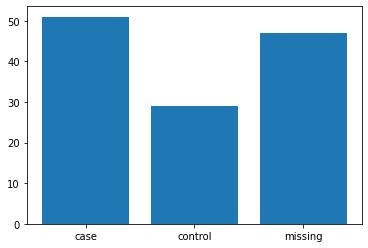

In [32]:
countRemission(EarthA_fam)

(34, 32, 0)

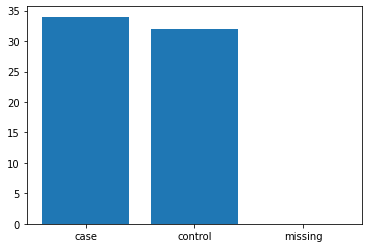

In [33]:
countRemission(EarthB_fam)